<a href="https://colab.research.google.com/github/s1c5000/tensorflow2.0/blob/main/%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#강화학습

###Gym : OpenAI에서 만들어놓은 강화학습 환경

문제가주어진 환경(environment)     
강화학습문제를 출기위하 에이전트(agent)      
에이전트의 행동(action)      
보상(reward)     
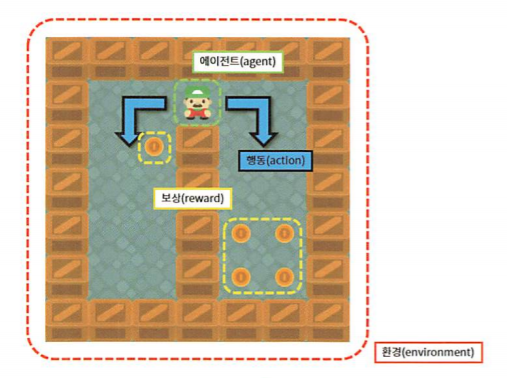

MountainCar-v0      
바퀴달린차(agent) 로 언덕(environment) 를 올라가는 문제     
보상은 각 시간 단위(time step)마다 -1이 주어지고, 오른쪽의 깃발에 도달하면 하나의 에피소드(episode)가 끝난다.     
즉 보상은 음수로 주어지며 에피소드를 빨리 끝낼수록 한 에피소드에 얻는 보상의 총합이 커지기 때문에 짧은시간내에 언덕을 올라야한다     
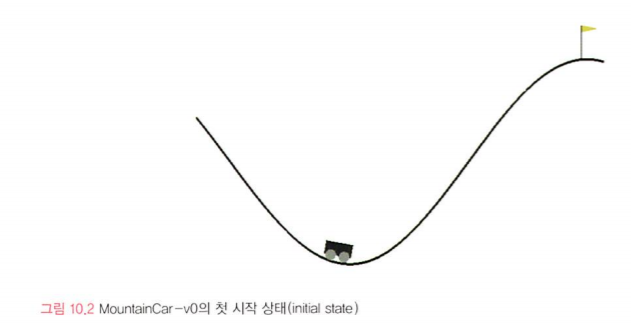

에이전트가 취할 수 있는 행동은("왼쪽으로이동", "정지", "오른쪽으로 이동") 3가지이다.      
하지만 오른쪽으로 이동하는 행동은 가파른 언덕을 올라갈만큼 충분히 크지않다.     
따라서 에이전트는 왼쪽오른쪽 반복해서 움직이며 가속도를 붙인 뒤 언덕을 올라갈 수 있다

In [ ]:
# 텐서플로 2 버전 선택
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)
# 현재 model.predict() 의 속도가 느린 문제가 있어서 eager_execution을 끕니다.
# 관련 버그 이슈 링크: https://github.com/tensorflow/tensorflow/issues/32104
tf.compat.v1.disable_eager_execution()
import numpy as np

2.3.0


In [ ]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

!apt-get update
!apt-get install cmake
!pip install --upgrade setuptools
!pip install ez_setup
!pip install gym[atari]

!pip install box2d-py
!pip install gym[Box_2D]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 22 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,682 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.6 [783 kB]
Fetched 1,280 kB in 1s (1,442 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144618 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.6_amd

In [ ]:
!pip install pyglet

In [ ]:
# 10.1 MountainCar-v0 환경 만들기
import gym
import random
env = gym.make('MountainCar-v0')

In [ ]:
# 10.2 환경의 관찰 공간, 행동 공간 변수 확인
print(env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)
print()
print(env.action_space)
print()
print(env._max_episode_steps)

Box(2,)
[-1.2  -0.07]
[0.6  0.07]

Discrete(3)

200


observation space는 에이전트가 환경을 볼 수 있는 작은 창이다    
에이전트는 관찰공간을 통해서만 환경의 정보를 파악할 수 있다.     
Box(2,)의 박스는 최댓값과 최솟값을 같는 범위라는 뜻, 2는 차원의 수     
즉 관찰공간은 2개의 숫자로 이루어지며, 각 최댓값과 최솟값을 갖는다

env.observation_space.low와 env.observation_space.high는 이 최댓값과 최솟값이 몇인지 표시       
첫번째 숫자는 차의 X축 좌표, 두번째는 차의 속도(음수면 왼쪽, 양수면 오른쪽)      

정리해보면 차는 X좌표 -1.2부터 0.6까지 움직이고, 최대 속도는 0.07, 최소속도는 -0.07       
종료조건은 차가 0.5(깃발위치)에 도달했을때 이다.     
각 에피소드가 시작될때(환경이 초기화될때) 차는 -0.6에서 -0.4사이의 랜덤한 위치에서 시작된다

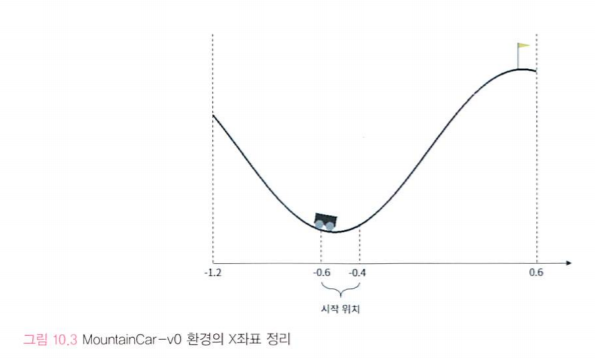

행동공간(action space)는 에이전트가 취할 수 있는 경우의 수를 나타냄       
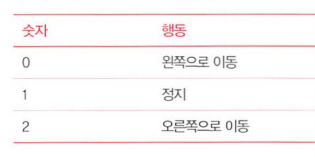

모든 에피소드는 종료조건이 있다 .깃발에 도달 하는 것도 종료 조건이지만 최대사간 단위의 제한을 둬서 에피소드가 무한히 계속되는 것을 방지한다.

먼저 랜덤한 행동을 하는 에이전트를 실행해보겠다.     
본격적인 학습에 들어가기 전 랜덤한 행동을 하는 에이전트를 투입해보는것은 환경을 파악하고 학습전략을 짜는데 도움을 준다

In [ ]:

# 10.3 랜덤한 행동을 하는 에이전트 실행
step = 0
score = 0
env.reset()

while True:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print(score)
    score += reward
    step += 1
    
    if done:
        break

print('score:', score)
print('step:', step)

0
-1.0
-2.0
-3.0
-4.0
-5.0
-6.0
-7.0
-8.0
-9.0
-10.0
-11.0
-12.0
-13.0
-14.0
-15.0
-16.0
-17.0
-18.0
-19.0
-20.0
-21.0
-22.0
-23.0
-24.0
-25.0
-26.0
-27.0
-28.0
-29.0
-30.0
-31.0
-32.0
-33.0
-34.0
-35.0
-36.0
-37.0
-38.0
-39.0
-40.0
-41.0
-42.0
-43.0
-44.0
-45.0
-46.0
-47.0
-48.0
-49.0
-50.0
-51.0
-52.0
-53.0
-54.0
-55.0
-56.0
-57.0
-58.0
-59.0
-60.0
-61.0
-62.0
-63.0
-64.0
-65.0
-66.0
-67.0
-68.0
-69.0
-70.0
-71.0
-72.0
-73.0
-74.0
-75.0
-76.0
-77.0
-78.0
-79.0
-80.0
-81.0
-82.0
-83.0
-84.0
-85.0
-86.0
-87.0
-88.0
-89.0
-90.0
-91.0
-92.0
-93.0
-94.0
-95.0
-96.0
-97.0
-98.0
-99.0
-100.0
-101.0
-102.0
-103.0
-104.0
-105.0
-106.0
-107.0
-108.0
-109.0
-110.0
-111.0
-112.0
-113.0
-114.0
-115.0
-116.0
-117.0
-118.0
-119.0
-120.0
-121.0
-122.0
-123.0
-124.0
-125.0
-126.0
-127.0
-128.0
-129.0
-130.0
-131.0
-132.0
-133.0
-134.0
-135.0
-136.0
-137.0
-138.0
-139.0
-140.0
-141.0
-142.0
-143.0
-144.0
-145.0
-146.0
-147.0
-148.0
-149.0
-150.0
-151.0
-152.0
-153.0
-154.0
-155.0
-156.0
-157.0
-158.0


env.reset()명령으로 환경을 초기화했다. 초기화하지않으면 정상적으로 실행되지 않을 수 있다.

action = env.action_space.smaple()    
action변수에 에이전트가 취할 수 있는 0,1,2 중하나가 랜덤하게 들어간다.

obs, reward, done, info = env.step(action)    
환경(env)에 에이전트가 행동(action)을 전달 함과 동시에 시간 단위(step)가 흘러간다.     
그 결과 환경이 영향을 받아서 바뀐 상태(obs)(좌표, 속도) , 보상(reward), 에피소드가 종료됐는지 여부(done), 그리고 기타정보(info)를 받는다.

원래 gym은 환경의 그래픽을 그려주는 render()함수가 있는데 코랩에서는 사용할 수없다.     
대신 한 에피소드의 실행결과를 mp4로 보여주는 방법을 사용하겠다

In [ ]:
# env.render() 함수의 결과를 mp4 동영상으로 보여주기 위한 코드
# from https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env
  
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# 10.4 랜덤 행동 에이전트의 환경 실행 결과 확인
env = wrap_env(gym.make('MountainCar-v0'))
env.reset()

score = 0
step = 0
while True:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    score += reward
    step += 1
    print(obs)
    if done:
        break

print('score:', score)
print('step:', step)
env.close()
show_video()

[-0.50406161 -0.00115509]
[-5.04363145e-01 -3.01537177e-04]
[-0.50380887  0.00055428]
[-0.50240293  0.00140594]
[-0.50115585  0.00124708]
[-5.01076972e-01  7.88820292e-05]
[-5.01166875e-01 -8.99030109e-05]
[-0.50242489 -0.00125802]
[-0.5048416  -0.00241671]
[-0.50739892 -0.00255732]
[-0.50907769 -0.00167877]
[-0.51086533 -0.00178764]
[-0.51174845 -0.00088312]
[-0.51272043 -0.00097198]
[-0.51377398 -0.00105355]
[-0.51590121 -0.00212723]
[-0.51908616 -0.00318495]
[-0.52330496 -0.0042188 ]
[-0.52852596 -0.005221  ]
[-0.53271001 -0.00418405]
[-0.53782573 -0.00511572]
[-0.54283478 -0.00500905]
[-0.54869964 -0.00586486]
[-0.55337643 -0.00467678]
[-0.55883018 -0.00545375]
[-0.56502018 -0.00619   ]
[-0.57090032 -0.00588014]
[-0.5774269  -0.00652657]
[-0.58255151 -0.00512461]
[-0.58723628 -0.00468477]
[-0.59144666 -0.00421038]
[-0.59515169 -0.00370503]
[-0.59832418 -0.00317249]
[-0.60194091 -0.00361674]
[-0.60397548 -0.00203456]
[-6.04413040e-01 -4.37562989e-04]
[-0.60325042  0.00116262]
[-0.60

200스텝이 되기전에 깃발에 도착하지 못한다.

문제를 풀기위해선 여러번의 에피소드 중 성공적인 에피소드를 저장한다음, 그때 행동했던 데이터를 신경망에 학습시키는방법을 사용해 볼 수 있다.

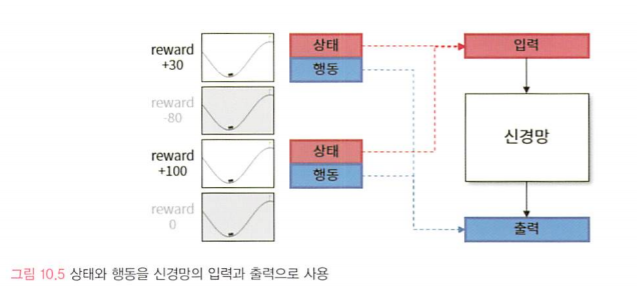

먼저 신경망을 학습시킬 데이터를 확보하는 코드가 필요하다. 랜덤한 행동을 하는 에이전트로 10000에피소드를 실행하고 그중 성공적인 에피소드의 데이터를 저장하겠다.

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
-199.921
[-196.0, -184.0, -178.0, -182.0, -184.0, -190.0, -172.0, -188.0, -184.0, -168.0, -184.0, -192.0, -186.0, -174.0, -194.0, -194.0, -190.0, -170.0, -168.0, -190.0, -166.0, -190.0, -192.0, -166.0, -184.0, -174.0, -190.0, -182.0, -180.0, -194.0, -176.0, -194.0, -178.0, -180.0, -184.0, -182.0, -182.0, -170.0, -172.0, -196.0, -180.0, -190.0, -194.0, -186.0, -182.0, -186.0, -192.0]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


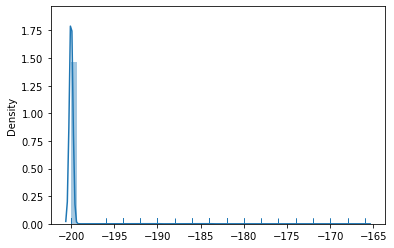

In [ ]:
# 10.5 성공적인 에피소드 저장
env = gym.make('MountainCar-v0')

scores = []
training_data = []
accepted_scores = []
required_score = -198

for i in range(10000):
    if i % 100 == 0:
        print(i)
    env.reset()
    score = 0
    game_memory = [] #입력데이터와 출력 데이터를 저장하기 위한 game_memory변수
    previous_obs = [] #이전 스텝의 관찰상태(좌표,속도)를 저장하기위한 변수
    
    while True:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        
        if len(previous_obs) > 0: # 이전상태가 존재할 경우 이전상태와 현재행동을 일단저장
            game_memory.append([previous_obs, action])
        
        #대부분의 에이전트들은 깃발에도달하지못하고 보상이 -200이다.
        #성곡적인 에피소드는 가속도를 이용해 약간이라도 앞으로 전진한 에피소드라고 정의
        #obs[0]은 X좌표, -0.2보다 오른쪽으로 갔을경우 보상을 1로 바꾼다.
        previous_obs = obs
        if obs[0] > -0.2:
            reward = 1
        
        score += reward
        
        if done:
            break
        
    #required_score(-198)보다 클경우, 즉 3번이상 -0.2보다 큰 x좌표값을 기록하면
    #성공적인 에피소드로판단해 training_data에 game_memory를 저장
    scores.append(score)
    if score > required_score:
        accepted_scores.append(score)
        for data in game_memory:
            training_data.append(data)

scores = np.array(scores)
print(scores.mean())
print(accepted_scores)

import seaborn as sns
sns.distplot(scores, rug=True)

In [ ]:
print(game_memory)
print(len(game_memory)) # 매 에피소드마다 200스탭이 있는데 처음은 저장하지않아서 199
print(len(accepted_scores))

[[array([-0.42416031, -0.00074008]), 0], [array([-0.42663517, -0.00247486]), 2], [array([-0.42882704, -0.00219187]), 0], [array([-0.43272016, -0.00389312]), 1], [array([-0.43728646, -0.0045663 ]), 1], [array([-0.44249289, -0.00520643]), 2], [array([-0.44730163, -0.00480874]), 1], [array([-0.45267761, -0.00537599]), 2], [array([-0.4575815 , -0.00490389]), 0], [array([-0.46397729, -0.00639579]), 2], [array([-0.46981786, -0.00584057]), 2], [array([-0.47506004, -0.00524218]), 0], [array([-0.48166497, -0.00660493]), 2], [array([-0.48758358, -0.00591861]), 2], [array([-0.49277178, -0.0051882 ]), 2], [array([-0.49719085, -0.00441907]), 0], [array([-0.50280777, -0.00561692]), 0], [array([-0.50958053, -0.00677275]), 1], [array([-0.51645839, -0.00687786]), 0], [array([-0.5243898 , -0.00793141]), 0], [array([-0.53331527, -0.00892548]), 2], [array([-0.54116789, -0.00785261]), 0], [array([-0.54988879, -0.00872091]), 0], [array([-0.55941273, -0.00952393]), 2], [array([-0.56766857, -0.00825585]), 2],

바뀐 보상식으로 계산한 score의 평균은 -199.921이 나온다.     
총 `10000회중 성공적인 에피소드는 47회이다.    
하지만 에피소드당 200스탭정도의 데이터가 있으니 10000개정도의 학습데이터가 존재하게된다.

In [ ]:

# 10.6 training_data 확인
training_data[:5]

[[array([-0.56957099, -0.00066121]), 0],
 [array([-0.57088851, -0.00131751]), 1],
 [array([-0.57185253, -0.00096403]), 0],
 [array([-0.57345592, -0.00160339]), 1],
 [array([-0.57468678, -0.00123085]), 1]]

첫번째 값은 관찰상태, 두번째 값은 행동이 들어가있다.

In [ ]:
# 10.7 훈련 데이터 만들기
# 행동을 레이블값으로 만든다.
train_X = np.array([i[0] for i in training_data]).reshape(-1, 2)
train_Y = np.array([i[1] for i in training_data]).reshape(-1, 1)
print(train_X.shape)
print(train_Y.shape)

(10149, 2)
(10149, 1)


In [ ]:
# 10.8 분류 신경망 정의
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer=tf.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 10.9 분류 신경망 학습
history = model.fit(train_X, train_Y, epochs=30, batch_size=16, validation_split=0.25)

Train on 7611 samples, validate on 2538 samples
Epoch 1/30
7520/7611 [============================>.] - ETA: 0s - loss: 1.0984 - accuracy: 0.3485WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
7611/7611 [==============================] - 1s 99us/sample - loss: 1.0985 - accuracy: 0.3475 - val_loss: 1.0998 - val_accuracy: 0.3286
Epoch 2/30
7611/7611 [==============================] - 1s 87us/sample - loss: 1.0974 - accuracy: 0.3462 - val_loss: 1.0984 - val_accuracy: 0.3286
Epoch 3/30
7611/7611 [==============================] - 1s 91us/sample - loss: 1.0953 - accuracy: 0.3588 - val_loss: 1.0944 - val_accuracy: 0.3936
Epoch 4/30
7611/7611 [==============================] - 1s 90us/sample 

약 40프로의 정확도를 보이는데 랜덤행동을 할때 33.3%보다 의미있는 행동이라는 지식을 얻은 것 같다

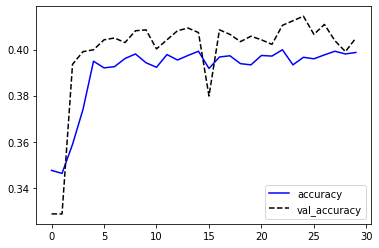

In [ ]:
# 10.10 분류 신경망 학습 결과 확인
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# 10.11 분류 신경망으로 에이전트 행동 확인
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

scores = []
steps = []
actions = []

for i in range(500):
    if i % 100 == 0:
        print(i)
    score = 0
    step = 0
    previous_obs = []
    env.reset()

    
    #학습데이터의 형태( 이전관찰상태, 현재행동)를 맞춰준다.

    #이전관찰상태가 없다면 랜덤한 행동을 선택하지만
    #그렇지 않다면 이전 관찰상태를 신경망에 입력으로 넣고 predict()함수로 넣어
    #logit을 계산한되 가장 큰 값을 가진 인덱스를 행동으로 선택한다.
    
    while True:
        if len(previous_obs) == 0:
            action = env.action_space.sample()
        else:
            logit = model.predict(np.expand_dims(previous_obs, axis=0))[0]
            action = np.argmax(logit)
            actions.append(action)
        
        obs, reward, done, info = env.step(action)
        previous_obs = obs
        score += reward
        step += 1

        if done:
            break
    
    scores.append(score)
    steps.append(step)

0
100
200
300
400


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055

-144.044


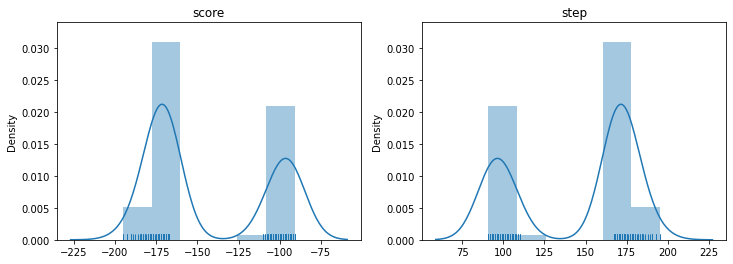

In [ ]:

# 10.12 score, step 분포 확인
# -200이 거의 보이지않는다.->200스탭안에 깃발에 도달
# 평균도 -144.044로 -199보다 많이 상승하였다.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title('score')
ax[1].set_title('step')
sns.distplot(scores, rug=True, ax=ax[0])
sns.distplot(steps, rug=True, ax=ax[1])

print(np.mean(scores))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


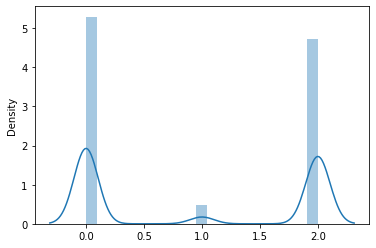

In [ ]:

# 10.13 행동 분포 확인
# 정지는 거의없고 왼쪽이나 오른쪽으로 이동하는 것을 볼 수 있다.
# 가속도를 붙이기 위해 비중이 높게나온다
sns.distplot(actions)

In [ ]:
# 10.14 분류 신경망 행동 에이전트 실행 결과 확인
env.close()
env = wrap_env(gym.make('MountainCar-v0'))
env.reset()

score = 0
step = 0
previous_obs = []
while True:
    if len(previous_obs) == 0:
        action = env.action_space.sample()
    else:
        logit = model.predict(np.expand_dims(previous_obs, axis=0))[0]
#         logit = logit.astype(float)
#         logit = logit / logit.sum()
#         prob = np.random.multinomial(1, logit)
#         action = np.argmax(prob)
        action = np.argmax(logit)
    
    obs, reward, done, info = env.step(action)
    previous_obs = obs
    score += reward
    step += 1
    
    if done:
        break

print('score:', score)
print('step:', step)
env.close()
show_video()

score: -93.0
step: 93
